In [1]:
import numpy as np

In [2]:
class Point:
    def __init__(self, 
                 position=[0, 0, 0], 
                 speed=[0, 0, 0], 
                 forces=[0, -9.81, 0],
                 mass=1.):
        self.position = np.array(position)
        self.previous_position = np.array(position)
        self.speed = np.array(speed)
        self.previous_speed = np.array(speed)
        self.forces = np.array(forces)
        self.previous_forces = np.array(forces)
        self.mass = mass
        
    def compute_new_position(self, delta_t):
        self.previous_position = self.position
        self.position = self.position + delta_t * self.speed
        
    def compute_new_speed(self, delta_t):
        self.previous_speed = self.speed
        self.speed = self.speed + delta_t * self.forces / self.mass
        

In [3]:
class Environment:
    def __init__(self, points, delta_t):
        self.points = points
        self.delta_t = delta_t
        self.history = [[p.position for p in points]]
    
    def compute_step(self):
        for p in self.points:
            p.compute_new_position(delta_t=self.delta_t)
            p.compute_new_speed(delta_t=self.delta_t)
        self.history.append([p.position for p in self.points])
        
    def run_episode(self, nb_steps=10):
        for i in range(nb_steps):
            self.compute_step()
            
        

In [4]:
points = [
    Point(speed=[3, 0, 0]),
    Point(speed=[3, 1, 0]),
    Point(speed=[3, 2, 0]),
    Point(speed=[3, 3, 0]),
    Point(speed=[2, 3, 0]),
    Point(speed=[1, 3, 0]),
    Point(speed=[0, 3, 0]),
]



In [5]:
env = Environment(points=points, delta_t=0.1)

env.run_episode(nb_steps=10)

In [6]:
a = np.array(env.history)

In [7]:
a.shape

(11, 7, 3)

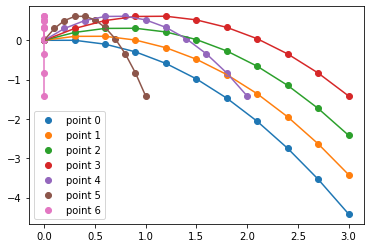

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(points)):
    plt.scatter(a[:, i, 0], a[:, i, 1], label='point {}'.format(i))
    plt.plot(a[:, i, 0], a[:, i, 1])

plt.legend()
plt.show()

In [9]:
a[:, 0]

array([[ 0.    ,  0.    ,  0.    ],
       [ 0.3   ,  0.    ,  0.    ],
       [ 0.6   , -0.0981,  0.    ],
       [ 0.9   , -0.2943,  0.    ],
       [ 1.2   , -0.5886,  0.    ],
       [ 1.5   , -0.981 ,  0.    ],
       [ 1.8   , -1.4715,  0.    ],
       [ 2.1   , -2.0601,  0.    ],
       [ 2.4   , -2.7468,  0.    ],
       [ 2.7   , -3.5316,  0.    ],
       [ 3.    , -4.4145,  0.    ]])

In [10]:
class Plane(Point):
    def __init__(self, 
                 position=[0, 0, 0], 
                 speed=[0, 0,0], 
                 mass=np.inf,  
                 forces=[0, 0, 0],
                 vector=[0, 1, 0],
                 width=None):
        Point.__init__(self, 
                       position=position, 
                       speed=speed, 
                       forces=forces, 
                       mass=mass)
        self.vector = np.array(vector) / np.linalg.norm(vector)
        self.width = width

In [11]:
class EnvironmentWithPlanes(Environment):
    def __init__(self, points, planes, delta_t):
        Environment.__init__(self, points=points, delta_t=delta_t)
        self.planes = planes
        self.impact_positions = []
        

    
    def compute_step(self):
        for p in self.points:
            p.compute_new_position(delta_t=self.delta_t)
            p.compute_new_speed(delta_t=self.delta_t)
            for plane in self.planes:
                self.impact_positions.append(compute_collision_point_vs_infinite_plane(p, plane, delta_t=self.delta_t))
        self.history.append([p.position for p in self.points])
        
            

In [12]:
def compute_collision_point_vs_infinite_plane(point, plane, delta_t, elasticity=1):
    projection_previous_point = np.dot(point.previous_position, plane.vector)
    projection_point = np.dot(point.position, plane.vector)
    projection_plane = np.dot(plane.vector, plane.position)


    if projection_point <= projection_plane:
        print(projection_point)

        delta_t_impact = delta_t *\
         (projection_previous_point - projection_plane) /\
         (projection_point - projection_plane)

        remaining_delta_t = delta_t - delta_t_impact
        
#         position_impact = point.previous_position + delta_t_impact * point.previous_speed
        position_impact = point.previous_position + (projection_point - projection_previous_point) * delta_t_impact / delta_t * plane.vector
        print(position_impact)
        speed_impact = elasticity * point.previous_speed

        speed_after_impact = speed_impact - 2 * np.dot(speed_impact, plane.vector) * plane.vector
        
        position_after_impact = position_impact + remaining_delta_t * speed_after_impact

        point.position = position_after_impact
        point.speed = speed_after_impact
        
        return position_impact

    # collision
#         print('collision')
        # position
#             point.position = point.position + 2 * (projection_plane - projection_point) * plane.vector
        # speed
#             point.speed = point.speed - 2 * np.dot(point.speed, plane.vector) * plane.vector

In [13]:
def compute_collision_point_vs_infinite_plane(point, plane, delta_t, elasticity=1.):
    projection_previous_point = np.dot(point.previous_position, plane.vector)
    projection_point = np.dot(point.position, plane.vector)
    projection_plane = np.dot(plane.vector, plane.position)


    if projection_point <= projection_plane:
#         print(projection_point)
        
        delta_t_impact = np.abs(delta_t *\
         (projection_previous_point - projection_plane) /\
         (projection_point - projection_previous_point))
        
#         print(delta_t_impact)
        
        impact_position = point.previous_position + delta_t_impact * point.previous_speed
        print(impact_position)
        
        new_speed = elasticity * (point.previous_speed - 2 * np.dot(point.previous_speed, plane.vector) * plane.vector + point.previous_forces * (delta_t - delta_t_impact) / point.mass)
        
        new_position = impact_position + new_speed * (delta_t - delta_t_impact)
        
        point.speed = new_speed
        point.position = new_position
        
        return impact_position

[2.5 3.5 0. ]
[2.5 3.5 0. ]
[3.14988987e+00 5.55111512e-17 0.00000000e+00]
[5.         2.48277791 0.        ]
[5. 1. 0.]
[4.00000000e+00 2.77555756e-17 0.00000000e+00]
[2.48470171 0.         0.        ]
[0.5 3.5 0. ]
[-2.09082479e+00  2.77555756e-17  0.00000000e+00]
[-3.  0.  0.]
[-6.5  3.5  0. ]
[-6.77176679  0.          0.        ]
[-10.   0.   0.]
[-11.50364065   0.           0.        ]
[-13.5   3.5   0. ]
[-16.4207051   0.          0.       ]
[-1.70000000e+01  2.77555756e-17  0.00000000e+00]
[-18.53604095   3.5          0.        ]
[-20.5   3.5   0. ]
[-2.07328977e+01 -5.55111512e-17  0.00000000e+00]
[-22.88430964   3.5          0.        ]
[-2.40000000e+01  2.77555756e-17  0.00000000e+00]
[-25.12710842   0.           0.        ]
[-26.98358034   3.5          0.        ]


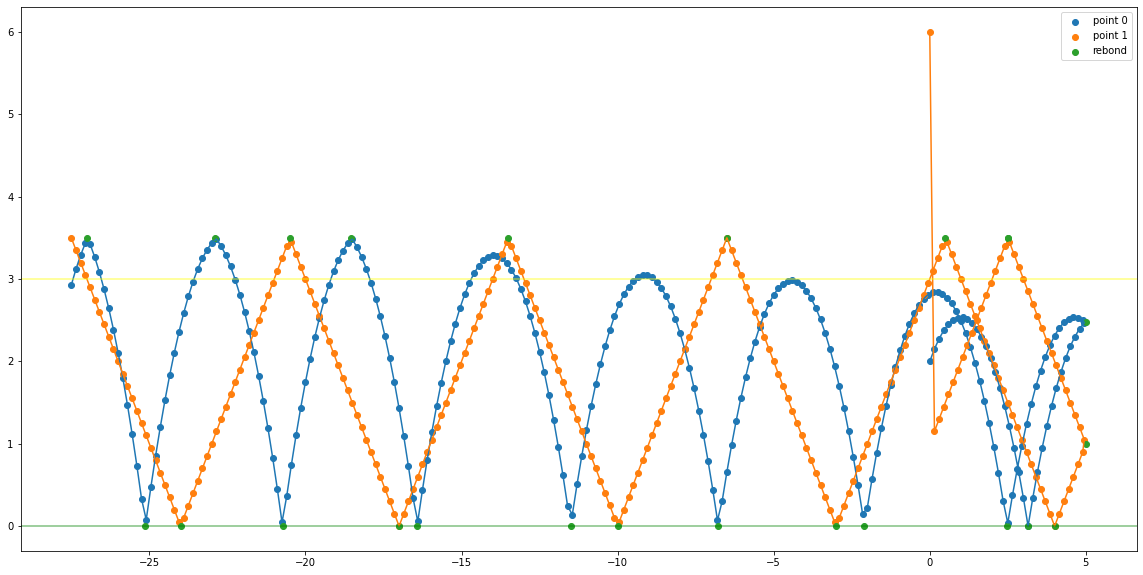

In [17]:
points = [
#     Point(speed=[3, 3, 0], position=[0, 0.1, 0]),
#     Point(speed=[3, 3, 0], position=[0, 0.2, 0]),
    Point(speed=[3, 3, 0], position=[0, 2, 0], forces=[0, -9.81, 0]),
    Point(position=[0, 6, 0], speed=[3, -3, 0], forces=[0, 0, 0])
]

planes = [
    Plane(),
    Plane(position=[5, 0, 0], vector=[-1, 0, 0]),
    Plane(position=[0, 3.5, 0], vector=[0, -1, 0])
]

env = EnvironmentWithPlanes(points=points, planes=planes, delta_t=.05)

env.run_episode(250)

a = np.array(env.history)
impacts = np.array([i for i in env.impact_positions if i is not None])


import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
for i in range(len(points)):
    plt.scatter(a[:, i, 0], a[:, i, 1], label='point {}'.format(i))
#     plt.annotate(xy=a[:, i, 0:1].T, text=a[:, i, 0:1])
    plt.plot(a[:, i, 0], a[:, i, 1])
plt.scatter(impacts[:, 0], impacts[:, 1], label='rebond')
plt.axhline(y=0, xmin=0, xmax=10, color='green', alpha=.5)
plt.axhline(y=3, xmin=0, xmax=10, color='yellow', alpha=.5)

plt.legend()
plt.show()

In [455]:
class Gravity(Environment):
    def __init__(self, planets, delta_t):
        Environment.__init__(self, points=planets, delta_t=delta_t)
        self.gravity_constant = 6.6742 / (10 ** 11)
    
    def compute_forces(self):
        planets = self.points
        nb_planets = len(planets)
        
        for i in range(nb_planets):
            self.points[i].forces = np.zeros(shape=3)
        
        for i in range(nb_planets):
            for j in range(i + 1, nb_planets):
                planet1 = planets[i]
                planet2 = planets[j]
                
                force1_2 =  - self.gravity_constant \
                * planet1.mass * planet2.mass * (planet1.position - planet2.position)\
                / np.power(np.linalg.norm(planet1.position - planet2.position),3)
#                 print(force1_2)

                self.points[i].forces = self.points[i].forces + force1_2
                self.points[j].forces = self.points[j].forces - force1_2

    def compute_step(self):
        self.compute_forces()
        for p in self.points:
#             print(p)
            p.compute_new_position(delta_t=self.delta_t)
            p.compute_new_speed(delta_t=self.delta_t)
        self.history.append([p.position for p in self.points])



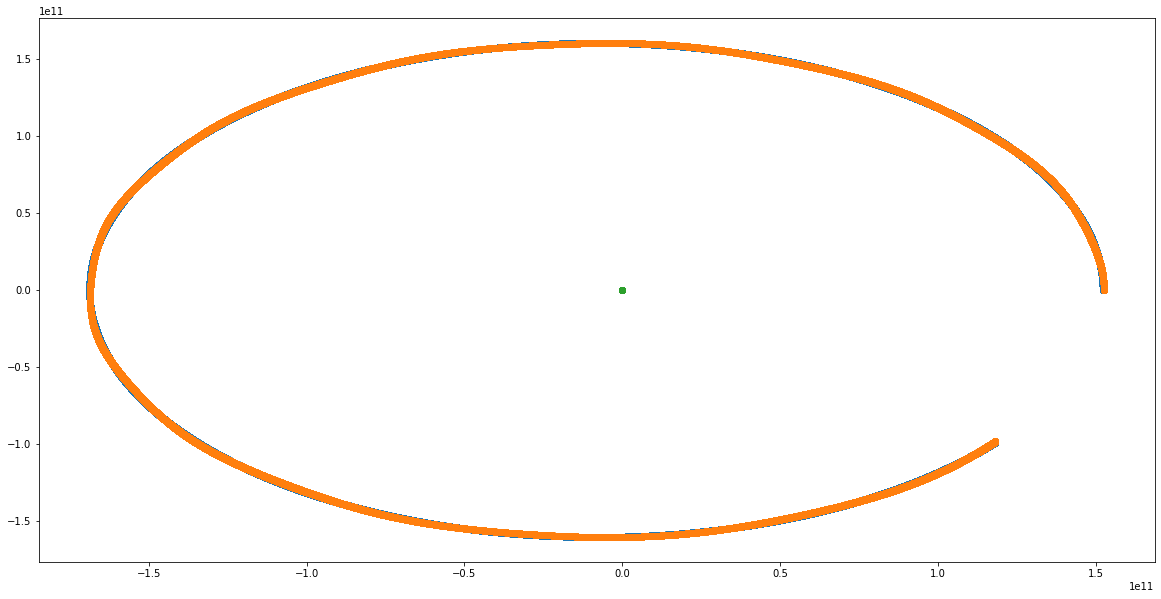

In [463]:
distance_terre_soleil = 152097701000 # aphelie
distance_terre_lune = 384400000

masse_soleil = 1.989 * (10**30)
masse_lune = 7.342 * (10**22)
masse_terre = 5.973 * (10**24)

vitesse_terre =  30.287 * 1000 # km/s 
# vitesse_terre = 29291
vitesse_lune = 1020


sol = Point(
    position=[0, 0, 0], 
    speed=[0, 0, 0],
    forces=[0, 0, 0], 
    mass=masse_soleil)


terra = Point(
    position=[distance_terre_soleil, 0, 0],
    speed=[0, vitesse_terre, 0],
    forces=[0, 0, 0],
    mass=masse_terre)

luna = Point(
    position=[distance_terre_lune + distance_terre_soleil, 0, 0],
    speed=[0, vitesse_terre + vitesse_lune, 0],
    forces=[0, 0, 0],
    mass=masse_lune)

planets = [
    terra, 
    luna, 
    sol
]

solar_system = Gravity(planets=planets, delta_t=360)

solar_system.run_episode(24 * 365 * 10)

a = np.array(solar_system.history)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
for i in range(len(planets)):
    plt.scatter(a[:, i, 0], a[:, i, 1], label='point {}'.format(i))
    
plt.show()

In [ ]:
solar_system.history = np.array(solar_system.history)

for j in range(len(solar_system.history)):
    plt.figure(figsize=(20, 20))
    plt.xlim(-1.7 * (10 ** 11), 1.7 * (10 ** 11))
    plt.ylim(-1.7 * (10 ** 11), 1.7 * (10 ** 11))
    for i in range(len(planets)):
        plt.scatter(solar_system.history[j, i:i+1, 0], solar_system.history[j, i:i+1, 1])
    plt.savefig('images/solar_system/frame_{:0>4d}.png'.format(j))
#     break
    

<ipython-input-476-3a38eda3ebcc>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 20))


In [470]:
solar_system.history.shape

AttributeError: 'list' object has no attribute 'shape'

In [381]:
10 ** 12

1000000000000

In [389]:
for p in solar_system.points:
    print(p.forces)

[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()
for f in range(a.shape[0]):
    for 
    frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
# ani.save('movie.mp4')
plt.show()